# Convolutional Neural Network IMBD

Proyecto para Interpretación de sentimientos con Lenguaje Natural

## Librerias

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk import ngrams as nltk_ngrams
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('words')
english_words = set(words.words())
import re
import string

lemmatizer = WordNetLemmatizer()

from collections import Counter


## Preprocesamiento de Datos

In [3]:
df = pd.read_csv("./Data/IMDB Dataset.csv")
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [4]:
#Convertir sentimiento a bolean
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)

In [5]:
df['review'][0:3]

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
Name: review, dtype: object

In [6]:
#Función de limpieza de texto
def preprocess_text(text):
    # Convertir a minúsculas
    text = text.lower()

    # Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', text)

    # Eliminar nombres propios
    text = re.sub(r'\b[A-Z][a-z]+(?:\'[a-z]+)?\b', '', text)

    # Eliminar frases entre comillas dobles
    text = re.sub(r'\".*?\"', '', text)

    # Eliminar contenido entre corchetes
    text = re.sub(r'\[.*?\]', '', text)

    # Eliminar puntuación
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)

    # Eliminar palabras con números
    text = re.sub(r'\w*\d\w*', '', text)

    # Eliminar caracteres repetidos
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Eliminar números
    text = re.sub(r'\d+', '', text)

    # Eliminar palabras muy largas o muy cortas
    text = ' '.join([word for word in text.split() if 2 <= len(word) <= 16])

    # Eliminar stopwords, conservando palabras específicas
    stop_words = set(stopwords.words('english'))
    keep_words = {'what', 'who', 'why', 'when', 'where', 'how'}  # Palabras importantes
    wordss = text.split()
    text = ' '.join([word for word in wordss if word not in stop_words or word in keep_words])

    # Filtrar palabras que contengan solo letras
    text = ' '.join([word for word in text.split() if word.isalpha()])

    # Filtrar palabras con prefijos anómalos
    text = ' '.join([word for word in text.split() if not word.startswith('aa')])
    # Lematización
    lemmatizerr = WordNetLemmatizer()
    text = ' '.join([lemmatizerr.lemmatize(word) for word in text.split()])

    return text


In [7]:
df_preprocessed = df.copy()

In [8]:
df_preprocessed['review'] = df_preprocessed['review'].apply(preprocess_text)

In [9]:
df_preprocessed['review']

0        one reviewer mentioned watching oz episode you...
1        wonderful little production filming technique ...
2        thought wonderful way spend time hot summer we...
3        basically there family where little boy jake t...
4        petter matteis visually stunning film watch mr...
                               ...                        
49995    thought movie right good job wasnt creative or...
49996    bad plot bad dialogue bad acting idiotic direc...
49997    catholic taught parochial elementary school nu...
49998    im going disagree previous comment side maltin...
49999    one expects star trek movie high art fan expec...
Name: review, Length: 50000, dtype: object

# EDA

### Longitud de reviews

In [107]:
df_preprocessed['largo'] = df_preprocessed['review'].apply(len)

In [108]:
df_preprocessed.describe()

,sentiment,largo
count,50000.000000,50000.000000
mean,0.500000,805.281820
std,0.500005,619.686709
min,0.000000,12.000000
25%,0.000000,424.000000
50%,0.500000,594.000000
75%,1.000000,982.000000
max,1.000000,9176.000000


### Correlación longitud y sentimiento

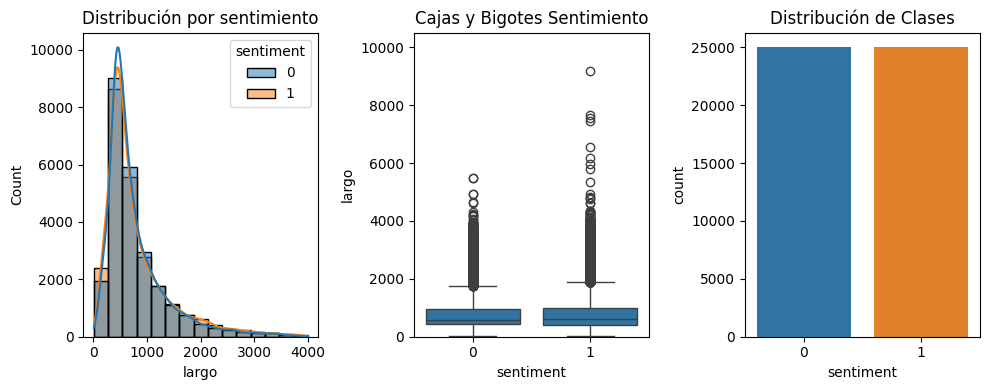

In [109]:
fig, ax = plt.subplots(1,3,figsize=(10,4))
ax[0].set_title('Distribución por sentimiento')
sns.histplot(df_preprocessed[df_preprocessed['largo'] < 4000],x='largo',hue='sentiment',kde=True,bins=15,ax=ax[0])

ax[1].set_title('Cajas y Bigotes Sentimiento')
sns.boxplot(df_preprocessed,x='sentiment',y='largo',ax=ax[1])
ax[1].set_ylim(0,10500)

ax[2].set_title('Distribución de Clases')
sns.countplot(df_preprocessed,x='sentiment',hue='sentiment',legend=False,ax=ax[2])

plt.tight_layout()
plt.show()


Creamos bigramas para hacer relación más rapidamente de las combinaciónes que definen un comentario positivo y negativo

### Análisis de bigramas

In [ ]:
def generate_ngrams(text, n):
    tokens = text.lower().split()
    n_grams = list(nltk_ngrams(tokens, n))  
    return n_grams

In [ ]:
n = 2  
df_preprocessed['ngrams'] = df_preprocessed['review'].apply(lambda x: generate_ngrams(x, n))

positive_ngrams = [ngram for sentiment, ngrams_list in zip(df_preprocessed['sentiment'], df_preprocessed['ngrams'])
                   if sentiment == 1 for ngram in ngrams_list]
negative_ngrams = [ngram for sentiment, ngrams_list in zip(df_preprocessed['sentiment'], df_preprocessed['ngrams'])
                   if sentiment == 0 for ngram in ngrams_list]

In [11]:
positive_ngram_counts = Counter(positive_ngrams)
negative_ngram_counts = Counter(negative_ngrams)

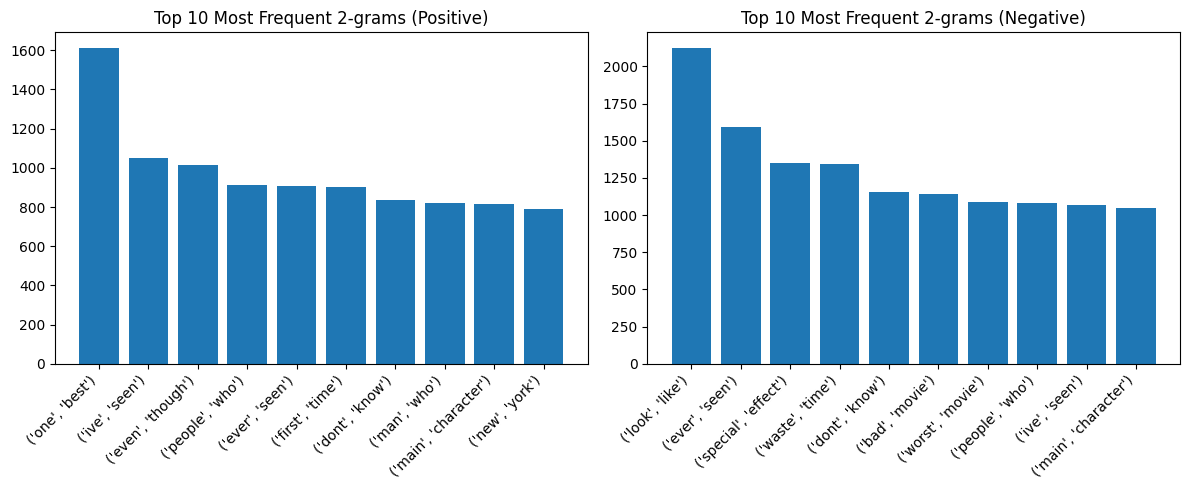

In [ ]:
# graficar los mejores 10 ngramas por categoria
top_n = 10

top_positive_ngrams = positive_ngram_counts.most_common(top_n)
top_negative_ngrams = negative_ngram_counts.most_common(top_n)


ngrams_pos = [str(ngram) for ngram, count in top_positive_ngrams]
counts_pos = [count for ngram, count in top_positive_ngrams]

ngrams_neg = [str(ngram) for ngram, count in top_negative_ngrams]
counts_neg = [count for ngram, count in top_negative_ngrams]



plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(ngrams_pos, counts_pos)
plt.title(f'Top {top_n} Most Frequent {n}-grams (Positive)')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(ngrams_neg, counts_neg)
plt.title(f'Top {top_n} Most Frequent {n}-grams (Negative)')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [14]:
df_preprocessed = df_preprocessed.drop(columns=['ngrams'])

### Análisis por categorias

In [85]:
positive_reviews = df_preprocessed[df_preprocessed['sentiment'] == 1]['review']
negative_reviews = df_preprocessed[df_preprocessed['sentiment'] == 0]['review']

In [86]:
# Categorías a analizar
categories = ['acting', 'story', 'script', 'plot', 'effects', 'visuals', 'sound', 'music', 'dialogue']

In [87]:
# Función para buscar frecuencia de las categorías
def category_analysis(reviews, categories):
    frequencies = {}
    #examples = {}
    for category in categories:
        frequencies[category] = reviews.str.contains(category, case=False, na=False).sum()
    return frequencies

In [88]:
# reseñas positivas
positive_freq = category_analysis(positive_reviews, categories)

# reseñas negativas
negative_freq = category_analysis(negative_reviews, categories)

In [90]:
freq_df = pd.DataFrame({'Positive': positive_freq, 'Negative': negative_freq})

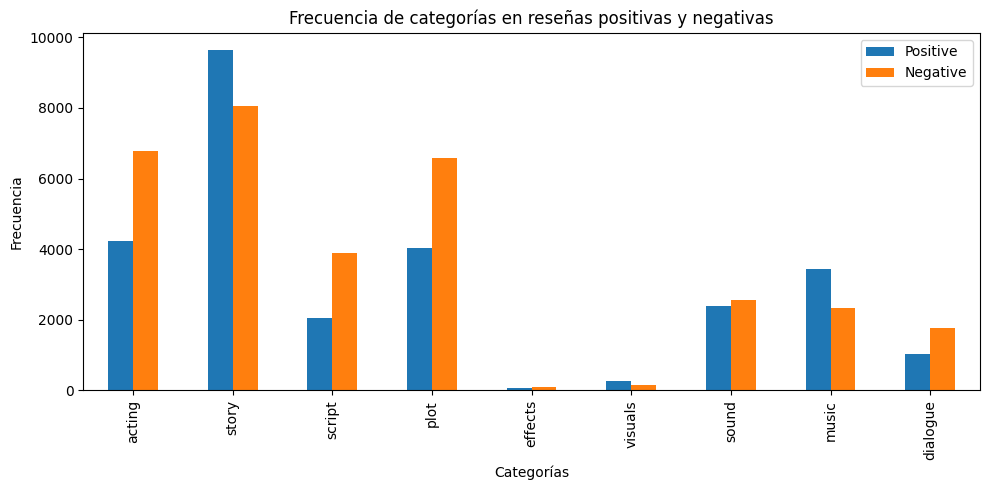

In [97]:
freq_df.plot(kind='bar', figsize=(10, 5))
plt.title('Frecuencia de categorías en reseñas positivas y negativas')
plt.ylabel('Frecuencia')
plt.xlabel('Categorías')
plt.tight_layout()
plt.show()

# Construcción de Red Neuronal Recurrente

## Capa de Vectorizacion

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import Embedding,  Dense, Dropout,LSTM,Input,Bidirectional

In [21]:
max_tokens=30000
output_seq_len=500
embedding_dim=128
batch_size=128 #tamaño de lotes
lstm_units=32

vectorize_layer=TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=output_seq_len
)
vectorize_layer.adapt(df_preprocessed['review'].values)

## Separación de Conjuntos

In [56]:
# Total de datos
n = len(df_preprocessed)

# índice de corte (90% train - 10% test)
cut = int(n * 0.9)

# Dividimos
X_text = df_preprocessed['review'].values
y_values = df_preprocessed['sentiment'].values

X = vectorize_layer(X_text[:cut])
y = y_values[:cut]

X_test = vectorize_layer(X_text[cut:])
y_test = y_values[cut:]


In [24]:
X.shape , y.shape

(TensorShape([45000, 500]), (45000,))

## Pipeline para entrenamiento

Pipeline de datos para entrenamiento:
carga > cachea > mezcla > agrupa en batches > prepara en paralelo

In [25]:
data=tf.data.Dataset.from_tensor_slices((X,y))  #dataset de tensorflow 
data=data.cache()                               #guarda datos en memoria útil trabajo en muchas epocas
data=data.shuffle(buffer_size=10000)            #evitar aprender patrones en el orden
data=data.batch(batch_size)                     #crea lotes para el entrenamiento
data=data.prefetch(tf.data.AUTOTUNE)            #trabajo en paralelo
data_iterator=data.as_numpy_iterator()          #Convierte el Dataset en un iterador de NumPy.


In [26]:
X_train=data.take(int(.8*len(data)))
X_val=data.skip(int(.8*len(data))).take(int(.2*len(data)+1))
print(f'Train size: {len(X_train)},\nValidation size: {len(X_val)},\nTotal size: {len(data)}')


Train size: 281,
Validation size: 71,
Total size: 352


## Estructura de la Red

In [29]:
def build_model():
    inputs=Input(shape=(output_seq_len,))
    x=Embedding(max_tokens+1,embedding_dim)(inputs)
    x=Dropout(.2)(x)
    x=Bidirectional(
        LSTM(lstm_units,return_sequences=True,dropout=0.2)
    )(x)
    x=Bidirectional(
        LSTM(lstm_units,dropout=.2)
    )(x)
    x=Dense(1,activation='sigmoid')(x)

    model=Model(inputs=inputs,outputs=x)
    return model

model=build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 500, 128)       │     3,840,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 500, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 500, 64)        │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,906,241 (14.90 MB)

 Trainable params: 3,906,241 (14.90 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

## Entrenamiento

In [ ]:
history=model.fit(
    X_train,
    epochs=20,
    validation_data=X_val,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs',write_images=True,write_steps_per_second=True),
        tf.keras.callbacks.ModelCheckpoint(filepath='ckpt.keras',verbose=1,save_best_only=True)
    ]
)

Epoch 1/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 727ms/step - accuracy: 0.7359 - loss: 0.5271
Epoch 1: val_loss improved from None to 0.31961, saving model to ckpt.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 222s 772ms/step - accuracy: 0.7903 - loss: 0.4651 - val_accuracy: 0.8734 - val_loss: 0.3196
Epoch 2/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8761 - loss: 0.3167
Epoch 2: val_loss did not improve from 0.31961
281/281 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8637 - loss: 0.3353 - val_accuracy: 0.8738 - val_loss: 0.3223
Epoch 3/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8887 - loss: 0.2801
Epoch 3: val_loss improved from 0.31961 to 0.24065, saving model to ckpt.keras
281/281 ━━━━━━━━━━━━━━━━━━━━ 358s 1s/step - accuracy: 0.8918 - loss: 0.2761 - val_accuracy: 0.9091 - val_loss: 0.2407
Epoch 4/20
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9218 - loss: 0.2097
Epoch 4: val_loss improved from 0.24065 to 0.19552, saving model to ckpt.keras
281/281 ━━━━━━━━━━━

In [ ]:
model.save('metadata')
tf.keras.models.save_model(model,'sentiment_classifier_v2.h5')

# Evaluación

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### Perdida y Accuracy en entrenamiento

In [36]:
df = pd.read_csv("./model_metrics.csv")

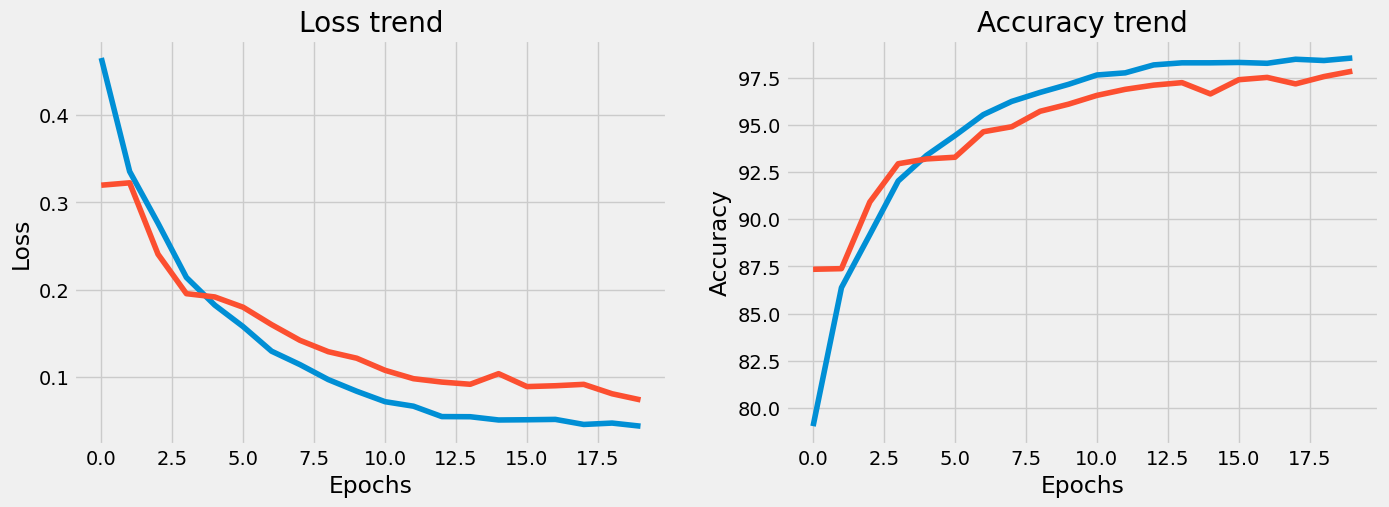

In [ ]:
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=2)
fig.set_figwidth(15)
fig.set_figheight(5)
ax[0].plot(df['loss'],label='loss')
ax[0].plot(df['val_loss'],label='val loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss trend')

ax[1].plot(df['accuracy']*100,label='accuracy')
ax[1].plot(df['val_accuracy']*100,label='val accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Accuracy trend')
plt.show()

In [ ]:
model=tf.keras.models.load_model('sentiment_classifier_v2.h5',compile=False)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

Predicciones de test

In [ ]:
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

### Reporte de Clasificación

In [94]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

Precision: 0.8635
Recall: 0.8810
F1-score: 0.8721

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87      2530
           1       0.86      0.88      0.87      2470

    accuracy                           0.87      5000
   macro avg       0.87      0.87      0.87      5000
weighted avg       0.87      0.87      0.87      5000



### Matriz de Confusión

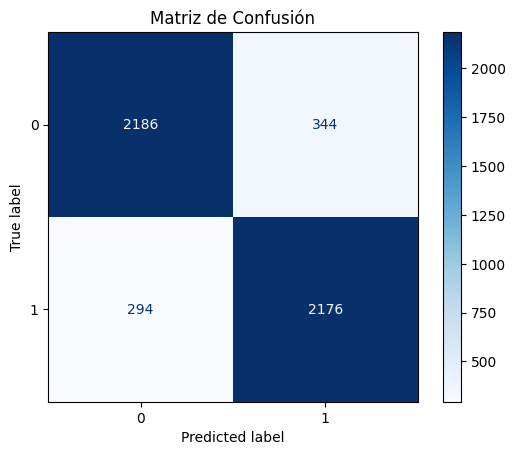

In [83]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()

### Cuva ROC

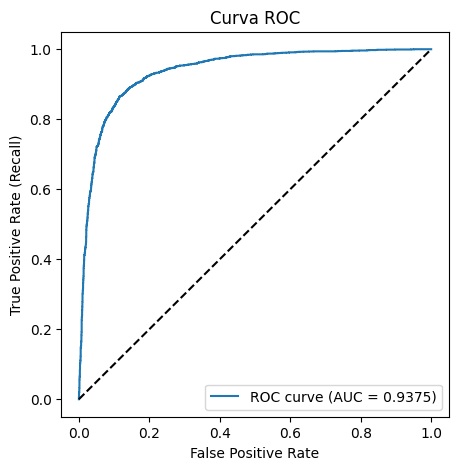

In [91]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


In [ ]:
def build_inference_model(model):
    inputs = Input(shape=(1,), dtype='string')  # <-- recibe texto crudo (strings)

    ids = vectorize_layer(inputs)               # <-- convierte texto en IDs/token indices
    outputs = model(ids)                        # <-- pasa esos IDs por tu modelo ya entrenado
    model = Model(inputs=inputs, outputs=outputs)  # <-- crea un nuevo modelo "end-to-end"
    return model

end2end_model=build_inference_model(model)

end2end_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
end2end_model.summary()

"end2end_model.compile(\n    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),\n    loss=tf.keras.losses.BinaryCrossentropy(),\n    metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])\nend2end_model.summary()"

In [137]:
def get_sentiment(reviews):
    reviews = list(map(preprocess_text, reviews))
    preds=end2end_model(np.array(reviews))
    preds=tf.squeeze(preds,axis=-1)
    temp=[]
    
    for pred in preds:
        temp.append({'Sentiment':'Positive','Confidence':pred.numpy()*100} if pred>.5 else ({'Sentiment':'Negative','Confidence':(1-pred).numpy()*100}))
    return temp

In [140]:
get_sentiment([
    "I absolutely loved this movie, it was fantastic!",
    "This was the worst film I have ever seen.",
    "The acting was great but the story was boring.",
    "What an amazing experience, I would watch it again.",
    "Terrible script and poor direction, not worth my time.",
    "It was okay, not good but not terrible either.",
    "The cinematography and music were breathtaking.",
    "I fell asleep halfway through, so boring!",
    "A masterpiece, truly one of the best films this year.",
    "Bad acting and predictable plot, I didn't enjoy it."
]
)

[{'Sentiment': 'Positive', 'Confidence': np.float32(97.75957)},
 {'Sentiment': 'Negative', 'Confidence': np.float32(99.74116)},
 {'Sentiment': 'Negative', 'Confidence': np.float32(94.79744)},
 {'Sentiment': 'Positive', 'Confidence': np.float32(99.264275)},
 {'Sentiment': 'Negative', 'Confidence': np.float32(99.94015)},
 {'Sentiment': 'Negative', 'Confidence': np.float32(97.05059)},
 {'Sentiment': 'Positive', 'Confidence': np.float32(93.3371)},
 {'Sentiment': 'Negative', 'Confidence': np.float32(99.97364)},
 {'Sentiment': 'Positive', 'Confidence': np.float32(98.6912)},
 {'Sentiment': 'Negative', 'Confidence': np.float32(99.58841)}]